Convolution and Interpolation

In [2]:
import numpy as np       #导入了NumPy库，并给它起了一个别名"np"。NumPy是一个用于进行数值计算的常用库。
import matplotlib.pyplot as plt     #从matplotlib库中导入了pyplot模块，并给它起了一个别名"plt"。matplotlib是一个用于绘制图表和可视化数据的库。
import matplotlib.image as mpimage   #从matplotlib库中的image模块，并给它起了一个别名"mpimage"。该模块提供了一些用于处理图像的函数和工具。
import scipy.ndimage    #了scipy库中的ndimage模块。该模块提供了一些用于图像处理和滤波的函数和工具。
from scipy import signal   #从scipy库中导入了signal模块。该模块提供了一些信号处理的函数和工具。
from scipy.signal.windows import lanczos     #从scipy库的signal模块中导入了lanczos函数。lanczos是一种窗函数，用于信号处理和图像处理中的平滑滤波。
 

def rgb2gray(rgb):      #这个函数将RGB图像转换为灰度图像。RGB图像的三个通道（红色、绿色、蓝色）与特定权重（0.2989、0.5870、0.1140）的乘积来计算灰度值。
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])    #点积操作，rgb[...,:3] 表示选择 RGB 图像的颜色通道。:3 表示选择最后一个维度的前三个元素，即选择 RGB 通道。

def gkern(kernlen=11, std=3):      #这个函数生成一个二维高斯核。它使用给定的核长度（kernlen）和标准差（std）来生成一个高斯分布，并将其归一化为总和为1的二维核。
    ax = np.linspace(-(kernlen - 1) / 2., (kernlen - 1) / 2., kernlen)   #np.linspace(start, stop, num) ，生成数组；通过在 2 后面添加小数点 .，可以明确指示 2 是一个浮点数而不是整数。
    gkern1d = np.exp(-0.5 * np.square(ax) / np.square(std))   #这是高斯函数中的指数部分
    gkern2d = np.outer(gkern1d, gkern1d)   #外积或叉乘
    return gkern2d/gkern2d.sum()    #得到的结果是一个归一化后的二维数组。

def lanczos_2d_h(length):
    lanczos_1d = lanczos(9)    #这个函数返回一个长度为 9 的 Lanczos 核数组
    lanczos_filter_2D = np.outer(lanczos_1d, lanczos_1d)
    lanczos_filter_2D = lanczos_filter_2D/lanczos_filter_2D.sum()   #归一化
    return lanczos_filter_2D

In the following cell, an RGB image is loaded and converted into a grayscale image to be used for the exercise.

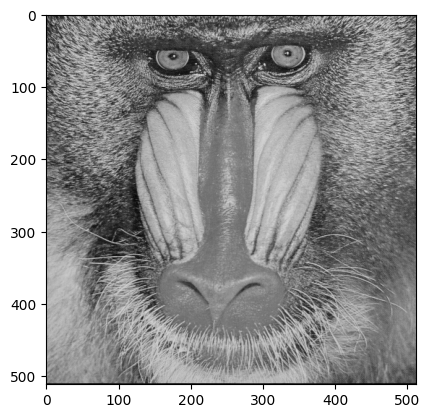

In [2]:
image = mpimage.imread('./dip_tut02/baboon.tiff') # image 4.2.03 from https://sipi.usc.edu/database/database.php?volume=misc
height = image.shape[0]
width = image.shape[1]
image_gray = rgb2gray(image).astype(int)     #astype(int) 将灰度图像的数据类型转换为整数型。应该是后续的滤波可能需要整数数据灰度图
fig = plt.figure()    #创建一个新的图形对象，用于容纳图像的显示。
plt.imshow(image_gray, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)   #目的是指定使用灰度颜色映射来显示图像，以突出显示灰度级别的变化。

Generate two averaging filter kernels of $n\times n $ length, one with 8 connected neighborhood and another with 4 connected neighborhood. Apply this filter to the  (hint提示: use `scipy.ndimage.convolve`). Assess the difference between the filtered image and the original image.

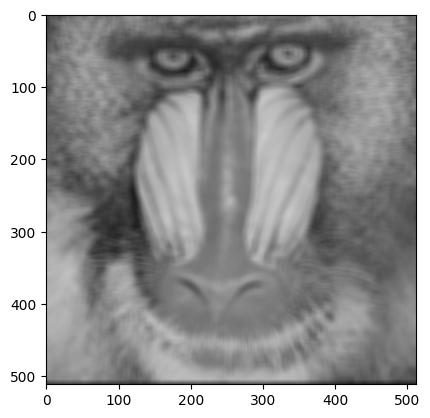

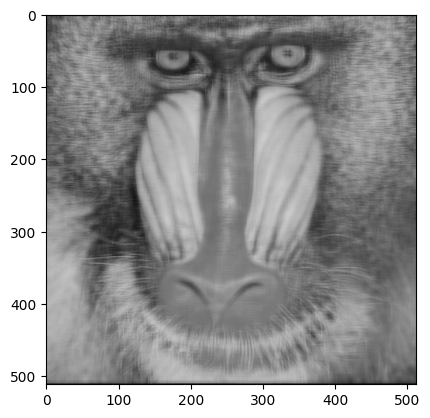

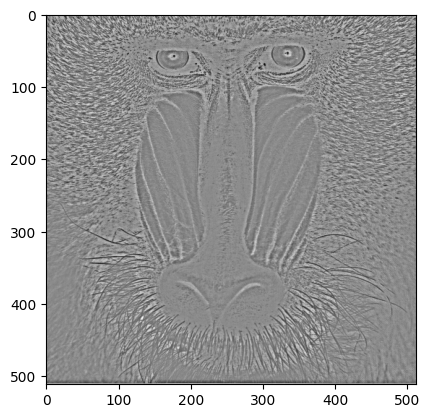

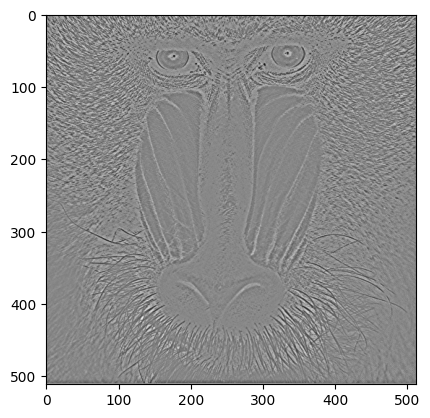

In [3]:
#filter length
n = 11 #(n is odd)

# averaging filter with a nxn kernel with 8 connected neighbors 
avg_filter_8con =  np.ones((n, n)) / (n * n)    #生成一个全为1的滤波器
image_avgfilter_8con = scipy.ndimage.convolve(image_gray, avg_filter_8con, mode='nearest')  #filtered image

#averaging filter with nxn kernel with 4 connected neighbors
avg_filter_4con = np.zeros((n, n))
m = int((n-1)/2)     #m = 5
for i in range(n):
    avg_filter_4con[m, i] = 1
    avg_filter_4con[i, m] = 1          #好巧的方法！
avg_filter_4con = avg_filter_4con / (2*n-1)    #将滤波器进行归一化
image_avgfilter_4con = scipy.ndimage.convolve(image_gray, avg_filter_4con, mode='nearest')

#difference image
diff_figure_8cn = image_avgfilter_8con - image_gray
diff_figure_4cn = image_avgfilter_4con - image_gray

#show figures
fig = plt.figure()
plt.imshow(image_avgfilter_8con, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
fig = plt.figure()
plt.imshow(image_avgfilter_4con, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
fig = plt.figure()
plt.imshow(diff_figure_8cn, cmap=plt.get_cmap('gray'), vmin=np.amin(diff_figure_8cn), vmax=np.amax(diff_figure_8cn))  #np.amax 是 NumPy 库中的一个函数，用于计算数组中的最大值。它的作用是返回给定数组的最大元素的值。
fig = plt.figure()
plt.imshow(diff_figure_4cn, cmap=plt.get_cmap('gray'), vmin=np.amin(diff_figure_4cn), vmax=np.amax(diff_figure_4cn))

Interpolation approximates intermediate samples between known samples while upscaling an image. A continuous bandpass signal sampled at a lower frequency than Nyquist rate would exhibit aliasing artifacts. To reduce the aliasing artifact, it is a common practice to apply lowpass filtering before applying decimation. In the following section, apply decimation with and without a lowpass filtering.
插值是在放大图像时用于近似已知样本之间的中间样本。如果对低于奈奎斯特率的频率进行采样的连续带通信号，会出现混叠伪影。为了减少混叠伪影，通常在进行抽取前先应用低通滤波。在下面的部分中，尝试使用和不使用低通滤波进行抽取。

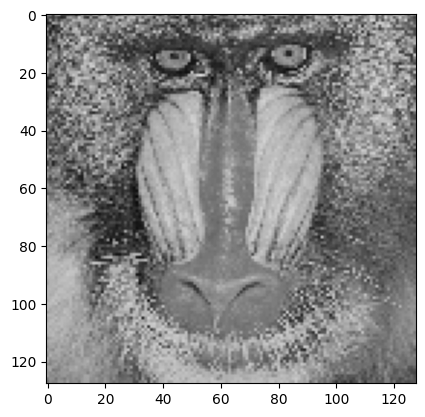

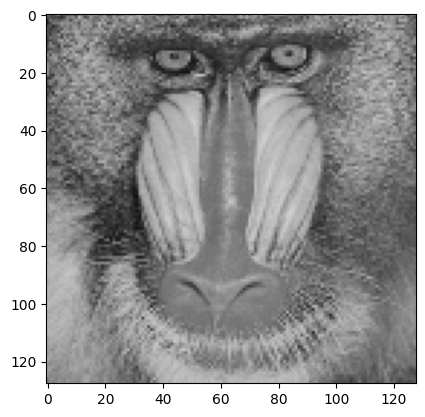

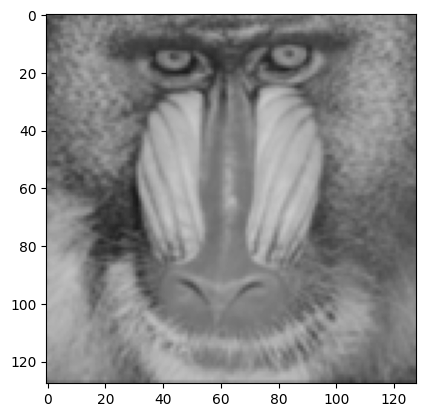

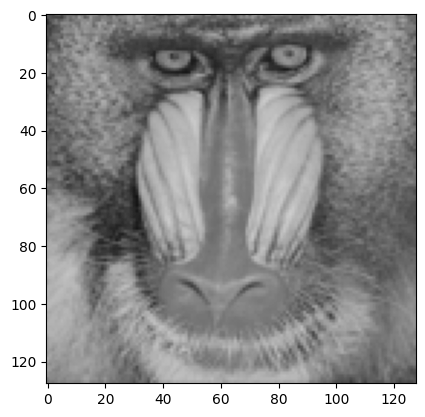

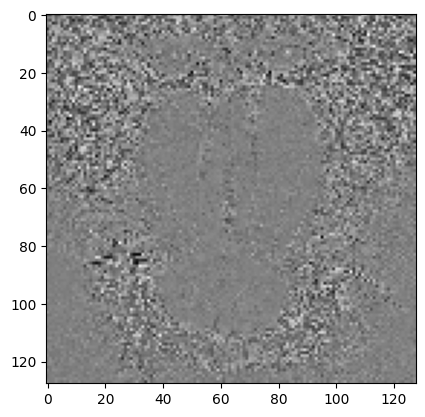

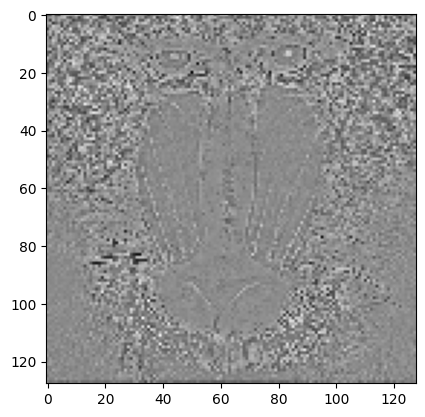

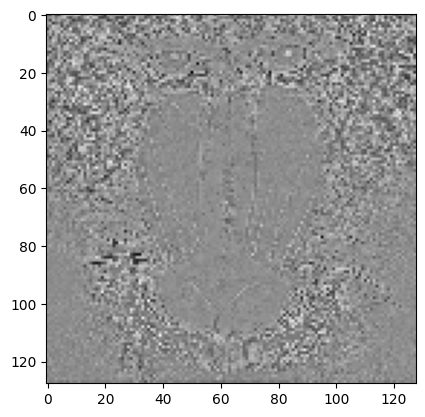

In [5]:
#subsampling, this is also used later as upscaling ratio for interpolation. This has to be an integer value.
resize_ratio = 4

#plain decimation
image_downsampled2_wo_lowpass = np.zeros((int(height/resize_ratio), int(width/resize_ratio)))     #用于存储抽样后的图像。
image_downsampled2_wo_lowpass = image_gray[0::resize_ratio, 0::resize_ratio]    #缩小到四分之一

#lowpass filtering with nxn averaging filter and decimation
#filter length
n = 3

# 定义nxn均值滤波器
avg_filter = np.ones((n, n)) / (n * n)

image_downsampled2_avgfilter = np.zeros((int(height/resize_ratio), int(width/resize_ratio)))    #用于存储平均滤波和抽样后的图像。

# 低通滤波和抽样操作并切片
image_downsampled2_avgfilter = scipy.ndimage.convolve(image_gray, avg_filter, mode='nearest')[0::resize_ratio, 0::resize_ratio]


#lowpass filtering with nxn gaussian filter and decimation（抽取）
#filter length
n = 11
gauss_filter = gkern(11, 2.5)  #第一个参数11表示滤波器的大小为11x11，第二个参数2.5表示高斯分布的标准差。
image_downsampled2_gaussfilter = np.zeros((int(height/resize_ratio), int(width/resize_ratio))) #存储滤波结果 

image_gaussfilter = scipy.ndimage.convolve(image_gray, gauss_filter, mode='nearest')    #卷积操作
image_downsampled2_gaussfilter = image_gaussfilter[0::resize_ratio, 0::resize_ratio]   #四分之一裁剪


#lowpass filtering with nxn lanczos filter and decimation    Lanczos函数是一种基于sinc函数的衰减窗函数，其形状类似于钟状曲线。
#filter length
n = 8
lanczos_filter_2D = lanczos_2d_h(n)
image_downsampled2_lanczosfilter = np.zeros((int(height/resize_ratio), int(width/resize_ratio)))
image_lanczosfilter = scipy.ndimage.convolve(image_gray, lanczos_filter_2D, mode='nearest')
image_downsampled2_lanczosfilter = image_lanczosfilter[0::resize_ratio, 0::resize_ratio]

diff_figure_avgfilter = image_downsampled2_avgfilter - image_downsampled2_wo_lowpass
diff_figure_gaussfilter = image_downsampled2_gaussfilter - image_downsampled2_wo_lowpass
diff_figure_lanczosfilter = image_downsampled2_lanczosfilter - image_downsampled2_wo_lowpass




#figures
fig = plt.figure()
plt.imshow(image_downsampled2_wo_lowpass, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
fig = plt.figure()
plt.imshow(image_downsampled2_avgfilter, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
fig = plt.figure()
plt.imshow(image_downsampled2_gaussfilter, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
fig = plt.figure()
plt.imshow(image_downsampled2_lanczosfilter, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
fig = plt.figure()
plt.imshow(diff_figure_avgfilter, cmap=plt.get_cmap('gray'), vmin=np.amin(diff_figure_avgfilter), vmax=np.amax(diff_figure_avgfilter))
fig = plt.figure()
plt.imshow(diff_figure_gaussfilter, cmap=plt.get_cmap('gray'), vmin=np.amin(diff_figure_gaussfilter), vmax=np.amax(diff_figure_gaussfilter))
fig = plt.figure()
plt.imshow(diff_figure_lanczosfilter, cmap=plt.get_cmap('gray'), vmin=np.amin(diff_figure_lanczosfilter), vmax=np.amax(diff_figure_lanczosfilter))


Nearest-neighbor and bilinear interpolation techniques are introduces in the lectures. In the follwing cells write the code to implement（执行） these interpolation techniques. Run the cells below to assess the reconstruction quality for each techniques. For evaluation MSE (mean squared error) and PSNR (peak signal to noise ratio) are calculated. The difference image between the interpolated image and the original image is shown.

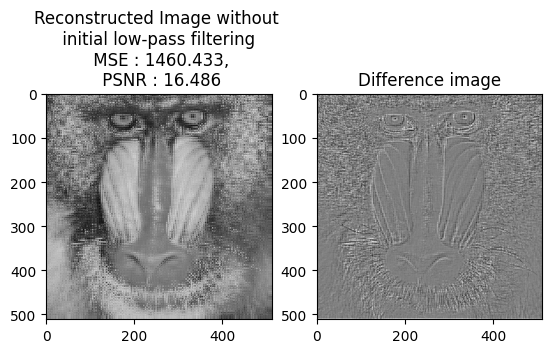

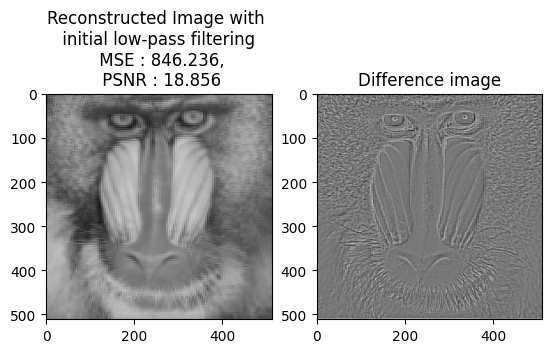

In [8]:
#set the downsampled image with lowpass filter to be used for interpolation
image_downsampled2_lp = image_downsampled2_lanczosfilter
scale = resize_ratio #upscaling ratio

# nearest neoghbor interpolation
def interpolate_nearest_neighbor(image_in, scale):
    height_in = image_in.shape[0]
    width_in = image_in.shape[1]
    
    # Calculate output dimensions
    height_out = height_in * scale + 1       #以确保适当的尺寸和边界像素的完整性。
    width_out = width_in * scale + 1
    
    # Pad the input image
    padded_image_in = np.pad(image_in, ((0, 1), (0, 1)), 'edge')    #上方填充 0 行，在下方填充 1 行，在左侧填充 0 列，在右侧填充 1 列填充值采用边缘像素的值。
    
    """
    对图像进行填充的目的是为了处理边界像素。在某些图像处理算法中，会对像素周围的邻域进行操作，例如滤波或插值。
    边界像素的处理可能会导致信息丢失或产生不准确的结果。
    通过对图像进行填充，可以扩展图像的尺寸，使得边界像素也能够参与到算法的计算中。
    填充操作通常会使用图像边缘像素的值进行填充，以保持填充区域与图像内容的一致性。
    常见的填充方式包括在边界周围复制像素值、使用恒定值填充或使用图像的对称反转来填充。具体的填充方式取决于应用场景和算法要求。
    因此，在图像处理中，填充操作有助于确保边界像素的正确处理，并避免由于边界像素导致的处理异常或错误。
    """

    """
    这些系数用于确定最近邻插值的权重。
    如果 i / scale 大于 0.5,则 r1 的值为 1,否则为 0。
    同样地，如果 j / scale 大于 0.5,则 r2 的值为 1,否则为 0。
    这样,r1 和 r2 决定了插值位置附近的原始像素的权重。

    这段代码是最近邻插值的核心实现部分。让我们逐行解释其含义：

    1. `array_out[i:height_out-1:scale, j:width_out-1:scale]`：这是一个切片操作，用于选择`array_out`数组中需要进行插值的位置。

    2. `image_in * (r1 * r2)`：这部分表示当前像素位置使用原始图像中的像素值进行插值。

    3. `padded_image_in[0:-1, 1:] * (r1 * (1 - r2))`：这部分表示当前像素位置的右方像素使用填充图像中的像素值进行插值。

    4. `padded_image_in[1:, 0:-1] * ((1 - r1) * r2)`：这部分表示当前像素位置的下方像素使用填充图像中的像素值进行插值。

    5. `padded_image_in[1:, 1:] * ((1 - r1) * (1 - r2))`：这部分表示当前像素位置的右下角像素使用填充图像中的像素值进行插值。

    这段代码通过逐个像素位置进行循环，根据最近邻插值算法的原理，在目标位置的周围像素中选择合适的像素值，并根据插值权重进行加权求和，最终将结果赋值给`array_out`数组中相应的位置，完成最近邻插值的操作。
    """
            
    
    array_out = np.zeros((height_out, width_out))
    
    for i in range(scale):
        for j in range(scale):
            r1 = 1 if (i / scale > 0.5) else 0
            r2 = 1 if (j / scale > 0.5) else 0     

            
    
            array_out[i:height_out-1:scale, j:width_out-1:scale] = (
                image_in * (r1 * r2) +
                padded_image_in[0:-1, 1:] * (r1 * (1 - r2)) +
                padded_image_in[1:, 0:-1] * ((1 - r1) * r2) +
                padded_image_in[1:, 1:] * ((1 - r1) * (1 - r2))
            )
    
    return array_out[:-1, :-1]


wolowpass_nn = np.zeros((height, width))
wolowpass_nn = interpolate_nearest_neighbor(image_downsampled2_wo_lowpass,scale)


lowpass_nn = np.zeros((height, width))
lowpass_nn = interpolate_nearest_neighbor(image_downsampled2_lp,scale)


diff_figure_wolp = wolowpass_nn - image_gray
diff_figure_lp = lowpass_nn - image_gray

#mse and psnr  均方误差（MSE）和峰值信噪比（PSNR）
nu_pixels = diff_figure_wolp.size   #通过调用.size属性可以获取该数组或图像的元素数量。这个元素数量即表示了数组或图像的大小或尺寸。
mse_wolp = np.sum(np.square(diff_figure_wolp))/nu_pixels
psnr_wolp = 10*np.log10((255*255)/mse_wolp)
mse_lp = np.sum(np.square(diff_figure_lp))/nu_pixels
psnr_lp = 10*np.log10((255*255)/mse_lp)

#figures
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(wolowpass_nn, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
ax1.title.set_text("Reconstructed Image without \n initial low-pass filtering \n MSE : {:.3f},\n PSNR : {:.3f}".format(mse_wolp,psnr_wolp))
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(diff_figure_wolp, cmap=plt.get_cmap('gray'),vmin=np.amin(diff_figure_wolp), vmax=np.amax(diff_figure_wolp) )
ax2.title.set_text("Difference image")

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(lowpass_nn, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
ax1.title.set_text("Reconstructed Image with \n initial low-pass filtering \n MSE : {:.3f},\n PSNR : {:.3f}".format(mse_lp,psnr_lp))
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(diff_figure_lp, cmap=plt.get_cmap('gray'), vmin=np.amin(diff_figure_lp), vmax=np.amax(diff_figure_lp))
ax2.title.set_text("Difference image")

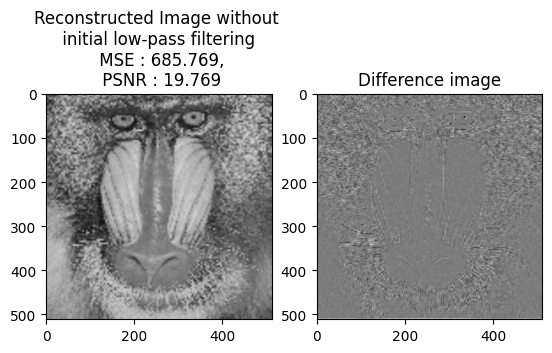

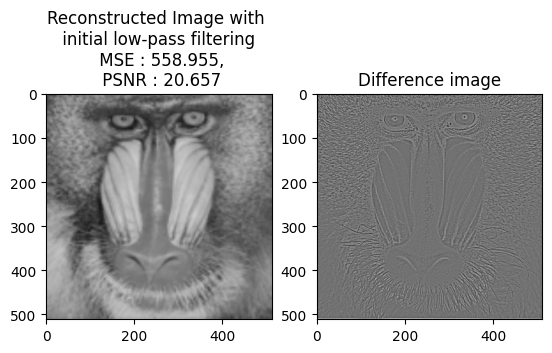

In [9]:
# bilinear interpolation
def interpolate_bilinear(image_in, scale):
    # Input image size: height_in x width_in
    height_in = image_in.shape[0]
    width_in = image_in.shape[1]
    
    # Output image size: height_out x width_out
    height_out = height_in * scale + 1
    width_out = width_in * scale + 1
    
    # Create a padded input image
    padded_image_in = np.zeros((height_in + 1, width_in + 1))
    padded_image_in[:height_in, :width_in] = image_in
    padded_image_in[:height_in, width_in] = padded_image_in[:height_in, width_in-1]
    padded_image_in[height_in, :] = padded_image_in[height_in-1, :]
    
    # Create an empty output image
    array_out = np.zeros((height_out, width_out))
    
    for i in range(scale):
        for j in range(scale):
            r1 = i / scale
            r2 = j / scale
            
            array_out[i:height_out-1:scale, j:width_out-1:scale] = (
                image_in * ((1 - r1) * (1 - r2)) +
                padded_image_in[0:-1, 1:] * ((1 - r1) * r2) +
                padded_image_in[1:, 0:-1] * (r1 * (1 - r2)) +
                padded_image_in[1:, 1:] * (r1 * r2)
            )
    
    return array_out[:-1, :-1]


# low passed downsampled
out_bl_lp = interpolate_bilinear(image_downsampled2_lp, scale)

# downsampled without low pass filtering
out_bl_wlp = interpolate_bilinear(image_downsampled2_wo_lowpass, scale)

diff_figure_bl_lp = out_bl_lp - image_gray
diff_figure_bl_wlp = out_bl_wlp - image_gray


#mse and psnr
nu_pixels = diff_figure_bl_lp.size
mse_bl_lp = np.sum(np.square(diff_figure_bl_lp))/nu_pixels
psnr_bl_lp = 10*np.log10((255*255)/mse_bl_lp)

nu_pixels = diff_figure_bl_wlp.size
mse_bl_wlp = np.sum(np.square(diff_figure_bl_wlp))/nu_pixels
psnr_bl_wlp = 10*np.log10((255*255)/mse_bl_wlp)


#figures
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(out_bl_wlp, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
ax1.title.set_text("Reconstructed Image without \n initial low-pass filtering \n MSE : {:.3f},\n PSNR : {:.3f}".format(mse_bl_wlp,psnr_bl_wlp))
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(diff_figure_bl_wlp, cmap=plt.get_cmap('gray'), vmin=np.amin(diff_figure_bl_wlp), vmax=np.amax(diff_figure_bl_wlp))
ax2.title.set_text("Difference image")

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(out_bl_lp, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
ax1.title.set_text("Reconstructed Image with \n initial low-pass filtering \n MSE : {:.3f},\n PSNR : {:.3f}".format(mse_bl_lp,psnr_bl_lp))
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(diff_figure_bl_lp, cmap=plt.get_cmap('gray'), vmin=np.amin(diff_figure_bl_lp), vmax=np.amax(diff_figure_bl_lp))
ax2.title.set_text("Difference image")

The cubic convolution function is an approximation of the $\mathrm{sinc}$ function by truncating its tail and enforcing the slope at the end to be zero to avoid a ripple effect. Implement cubic convolution interpolation in the following cell.

A control parameter $a$ is used to tune the approximation. $a = -1$ generates a function with the same slope at $x=1$ as a $\mathrm{sinc}$ function, whereas $a = -\frac{1}{2}$ guarantees lower sampling and interpolation error than a nearest neighbor and linear interpolation for sufficiently sampled scenes. Vary $a$ and notice the impact of $a$ on the reconstruction quality.
三次卷积函数是通过截断其尾部并强制其末端的斜率为零来近似 $\mathrm{sinc}$ 函数的方法，以避免出现纹波效应。请在下面的代码中实现三次卷积插值。

控制参数 $a$ 用于调整近似程度。当 $a = -1$ 时，生成的函数在 $x=1$ 处具有与 $\mathrm{sinc}$ 函数相同的斜率；而当 $a = -\frac{1}{2}$ 时，对于足够采样的场景，保证了比最近邻插值和线性插值更低的采样和插值误差。可以改变 $a$ 的值并观察其对重建质量的影响。

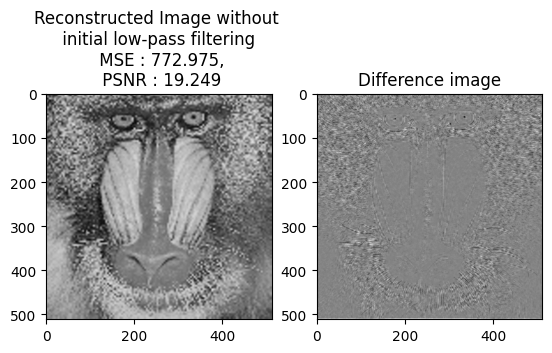

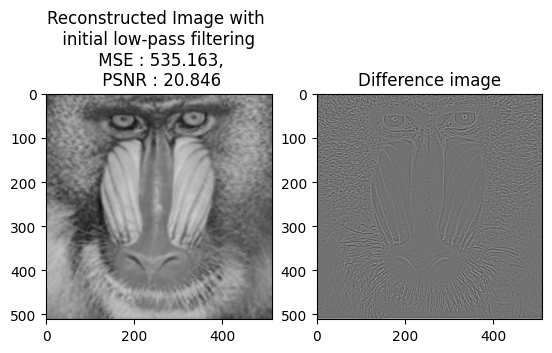

In [13]:
a = -0.6

def cubicconv_impact(t, a):
    if t <= 1:
        imp = (a + 2) * (abs(t) ** 3) - (a + 3) * (t ** 2) + 1
    elif t <= 2:
        imp = a * (abs(t) ** 3) - 5 * a * (t ** 2) + 8 * a * abs(t) - 4 * a
    else:
        imp = 0
    return imp


def interpolate_cubic_convolution(image_in, scale, slope):
    height_in = image_in.shape[0]
    width_in = image_in.shape[1]
    
    # Calculate output dimensions
    height_out = height_in * scale + 1
    width_out = width_in * scale + 1
    
    # Pad the input image
    padded_image_in = np.pad(image_in, ((1, 2), (1, 2)), 'edge')
    
    array_out = np.zeros((height_out, width_out))
    
    # 1D ratios - 1:(scale-1), 2:(scale-2), ..., (scale-1):1
    ratios_1 = np.arange(scale) / scale
    ratios_2 = 1 - ratios_1
    
    for i in range(scale):
        for j in range(scale):
            r1 = i / scale
            r2 = j / scale
            
            # Vertical cubic convolution
            x_p = np.zeros((height_in, width_in))
            for p in range(4):
                s_v = np.array([1 + r1, r1, 1 - r1, 2 - r1])
                x_q = np.zeros((height_in, width_in))
                
                # Horizontal cubic convolution
                for q in range(4):
                    s_h = np.array([1 + r2, r2, 1 - r2, 2 - r2])
                    x_q += padded_image_in[0 + p : 0 + p + height_in, 0 + q : 0 + q + width_in] * cubicconv_impact(s_h[q], slope)
                x_p += x_q * cubicconv_impact(s_v[p], slope)
            
            array_out[i : height_out - 1 : scale, j : width_out - 1 : scale] = x_p
    
    return array_out[:-1, :-1]


# low passed downsample
out_lp = interpolate_cubic_convolution(image_downsampled2_lp, scale, a)
#out_lp = out_1[0:-1,0:-1]


# without lowpass
out_wlp = interpolate_cubic_convolution(image_downsampled2_wo_lowpass, scale, a)
#out_wlp = out_1[0:-1,0:-1]


diff_figure_cc_lp = out_lp - image_gray
m1_lp = np.amin(diff_figure_cc_lp)
m2_lp = np.amax(diff_figure_cc_lp)

diff_figure_cc_wlp = out_wlp - image_gray
m1_wlp = np.amin(diff_figure_cc_wlp)
m2_wlp = np.amax(diff_figure_cc_wlp)


#mse
nu_pixels = diff_figure_cc_lp.size
mse_cc_lp = np.sum(np.square(diff_figure_cc_lp))/nu_pixels
psnr_cc_lp = 10*np.log10((255*255)/mse_cc_lp)

nu_pixels = diff_figure_cc_wlp.size
mse_cc_wlp = np.sum(np.square(diff_figure_cc_wlp))/nu_pixels
psnr_cc_wlp = 10*np.log10((255*255)/mse_cc_wlp)

#figures
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(out_wlp, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
ax1.title.set_text("Reconstructed Image without \n initial low-pass filtering \n MSE : {:.3f},\n PSNR : {:.3f}".format(mse_cc_wlp,psnr_cc_wlp))
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(diff_figure_cc_wlp, cmap=plt.get_cmap('gray'), vmin=m1_wlp, vmax=m2_wlp)
ax2.title.set_text("Difference image")

fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
ax1.imshow(out_lp, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)
ax1.title.set_text("Reconstructed Image with \n initial low-pass filtering \n MSE : {:.3f},\n PSNR : {:.3f}".format(mse_cc_lp,psnr_cc_lp))
ax2 = fig.add_subplot(1,2,2)
ax2.imshow(diff_figure_cc_lp, cmap=plt.get_cmap('gray'), vmin=m1_lp, vmax=m2_lp)
ax2.title.set_text("Difference image")

Additional paper-work question: A commonly known general interpolation technique is called spline interpolation. $n^{\text{th}}$ order spline basis function is derived by convolving zero-order hold (aka nearest neighbor) basis function. Derive the basis function of cubic spline (order 3). 

附加的文书工作问题:一个众所周知的一般插值技术被称为样条插值。$n^{\text{th}}$阶样条基函数是通过卷积零阶保持(又称最近邻)基函数得到的。导出三次样条的基函数(3阶)。

Cubic spline interpolation is a commonly used interpolation technique that involves fitting a piecewise cubic polynomial to a set of data points. To derive the basis function of a cubic spline, we start with the zero-order hold (nearest neighbor) basis function and convolve it to obtain higher-order spline basis functions.

三次样条插值是一种常用的插值技术，它涉及到将分段三次多项式拟合到一组数据点上。为了得到三次样条的基函数，我们从零阶保持器(最近邻)基函数出发，对其进行卷积得到高阶样条基函数。

The zero-order hold basis function, denoted as $B_0(x)$, is defined as follows:

0阶保持基函数记为$B_0(x)$，定义如下:

$B_0(x) = \begin{cases} 
      1 & 0 \leq x < 1 \\
      0 & \text{otherwise}
   \end{cases}$

To obtain the cubic spline basis function, we convolve the zero-order hold basis function three times with itself. Let's denote the cubic spline basis function as $B_3(x)$.

为了得到三次样条基函数，我们将零阶保持器基函数与自身进行了三次卷积。我们将三次样条基函数表示为B_3(x)。

$B_3(x) = B_0(x) * B_0(x) * B_0(x)$

To perform the convolution, we can express $B_3(x)$ in terms of its values at discrete intervals. Assuming a uniform grid with intervals of length 1, we can compute $B_3(x)$ for different intervals.

为了进行卷积，我们可以用它在离散区间的值来表示$B_3(x)$。假设一个间隔长度为1的均匀网格，我们可以计算不同间隔的$B_3(x)$。

For $0 \leq x < 1$, $B_3(x)$ can be expressed as:

$B_3(x) = \begin{cases} 
      1 - 2x^2 + x^3 & 0 \leq x < 1 \\
      0 & \text{otherwise}
   \end{cases}$

For $1 \leq x < 2$, $B_3(x)$ can be expressed as:

$B_3(x) = \begin{cases} 
      4 - 8x + 5x^2 - x^3 & 1 \leq x < 2 \\
      0 & \text{otherwise}
   \end{cases}$

For $2 \leq x < 3$, $B_3(x)$ can be expressed as:

$B_3(x) = \begin{cases} 
      4 - 8x + 5x^2 - x^3 & 1 \leq x < 2 \\
      0 & \text{otherwise}
   \end{cases}$

For $x \geq 3$, $B_3(x)$ is 0.

These expressions define the basis function of a cubic spline interpolation. The cubic spline basis function is used to interpolate data points by fitting cubic polynomials to each interval between data points.

这些表达式定义了三次样条插值的基函数。利用三次样条基函数对数据点之间的每个间隔拟合三次多项式来插值数据点。